# Tertiary Contacts

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from rna_motif_library.plotting import publication_style_ax
from rna_motif_library.util import parse_motif_name

In [2]:
df = pd.read_json("../unique_tertiary_contacts.json")
df_lora = pd.read_json("../lora_contacts_processed.json")
df_lora = df_lora[df_lora["in_our_db"] == False]

## comparision with lora

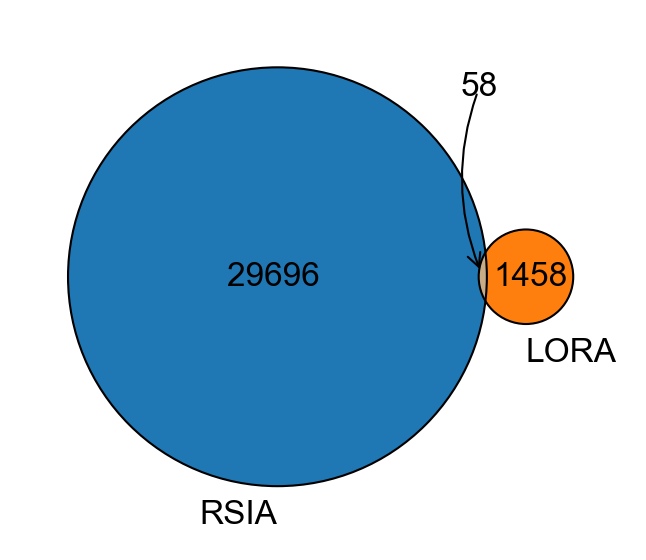

In [6]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

# Create the Venn diagram with seaborn default colors
colors = sns.color_palette()[:2]  # Get first two colors from default palette
v = venn2(subsets=(len(df), 1458, 58), set_labels=("RSIA", "LORA"), set_colors=colors,  alpha=1.0)
c = venn2_circles(subsets=(len(df), 1458, 58), linestyle="solid", lw=0.5)

# Get the center of the overlap region
overlap_center = v.get_label_by_id("11").get_position()

# Calculate arrow start position (slightly offset from center)
arrow_start = (0.50, 0.50)

# Add arrow pointing to overlap
ax.annotate(
    "",
    xy=overlap_center,  # Point to overlap
    xytext=arrow_start,  # Start from center of plot
    arrowprops=dict(
        arrowstyle="->", color="black", lw=0.5, connectionstyle="arc3,rad=0.2"
    ),
)  # Curved arrow

# Add text label at the base of the arrow
ax.text(arrow_start[0], arrow_start[1], "58", ha="center", va="center", fontsize=8)

# Hide the original overlap label
v.get_label_by_id("11").set_text("")

publication_style_ax(ax)

In [8]:
df_lora["reason"] = ""
df_lora.loc[
    (df_lora["more_than_2_motifs"] == True) & (df_lora["reason"] == ""), "reason"
] = "More than 2 motifs"
df_lora.loc[
    (df_lora["connected_strands"] == False) & (df_lora["reason"] == ""), "reason"
] = "Shared basepair"
df_lora.loc[(df_lora["hbond_score"] < 3) & (df_lora["reason"] == ""), "reason"] = (
    "Transient Interaction"
)
df_lora.loc[df_lora["reason"] == "", "reason"] = "Other"

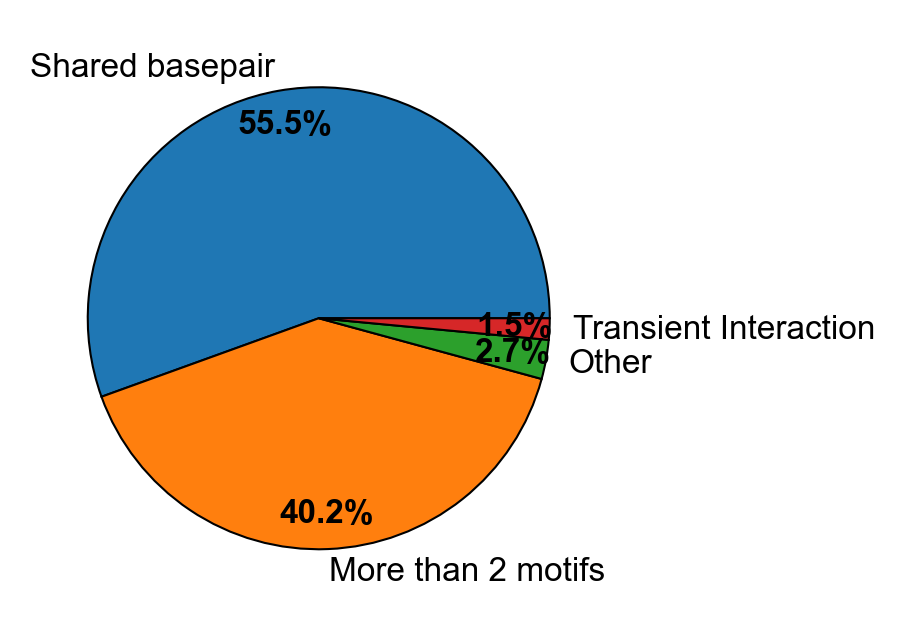

In [9]:
# Get value counts and sort in descending order
reason_counts = df_lora["reason"].value_counts()

# Filter out values less than 0.2%
total = reason_counts.sum()

# Create figure and axis
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

# Create pie chart with different colors
colors = sns.color_palette()[:len(reason_counts)]  # Use default color palette
wedges, texts, autotexts = ax.pie(
    reason_counts.values,
    labels=reason_counts.index,
    colors=colors,
    autopct="%1.1f%%",
    pctdistance=0.85,
    wedgeprops=dict(edgecolor="black", linewidth=0.5),
)

# Customize plot
plt.setp(autotexts, size=6, weight="bold", fontname="Arial")
plt.setp(texts, size=6, fontname="Arial")

publication_style_ax(ax)

## find examples

In [6]:
df.columns

Index(['motif_1', 'motif_2', 'mtype_1', 'mtype_2', 'm_size_1', 'm_size_2',
       'm_sequence_1', 'm_sequence_2', 'motif_1_res', 'motif_2_res', 'pdb_id',
       'num_hbonds', 'hbond_score', 'base-base', 'base-sugar', 'base-phos',
       'phos-sugar', 'phos-phos', 'unique_motif_1', 'unique_motif_2'],
      dtype='object')

In [7]:
df = df.sort_values("num_hbonds", ascending=False)

In [10]:
df_sub = df.query("mtype_1 == 'HELIX' and mtype_2 == 'SSTRAND'")
df_sub

,motif_1,motif_2,mtype_1,mtype_2,m_size_1,m_size_2,m_sequence_1,m_sequence_2,motif_1_res,motif_2_res,pdb_id,num_hbonds,hbond_score,base-base,base-sugar,base-phos,phos-sugar,phos-phos,unique_motif_1,unique_motif_2
22815,HELIX-10-AAAAAGAAAA-UUUUCUUUUU-6SVS-1,SSTRAND-17-XGAAGGUUUUUCUUUUU-6SVS-1,HELIX,SSTRAND,10,17,AAAAAGAAAA-UUUUCUUUUU,XGAAGGUUUUUCUUUUU,"[A-A-75-, A-A-77-, A-A-72-, A-A-69-, A-A-76-, ...","[A-U-13-, A-U-15-, A-U-10-, A-U-7-, A-U-14-, A...",6SVS,17,14.551044,10,0,0,7,0,True,True
1932,HELIX-10-AAAAAGCAAA-UUUGCUUUUU-4PLX-1,SSTRAND-16-XGAAGGUUUUUCUUUU-4PLX-1,HELIX,SSTRAND,10,16,AAAAAGCAAA-UUUGCUUUUU,XGAAGGUUUUUCUUUU,"[A-A-75-, A-A-67-, A-A-68-, A-G-71-, A-A-70-, ...","[A-U-15-, A-U-8-, A-U-9-, A-C-12-, A-U-11-, A-...",4PLX,17,13.203448,9,0,0,8,0,True,True
1935,HELIX-9-AAAAGCAAA-UUUGCUUUU-4PLX-1,SSTRAND-10-UUUUUCUUUU-4PLX-1,HELIX,SSTRAND,9,10,AAAAGCAAA-UUUGCUUUU,UUUUUCUUUU,"[B-A-67-, B-A-74-, B-A-68-, B-A-75-, B-A-73-, ...","[B-U-8-, B-U-14-, B-U-9-, B-U-15-, B-U-13-, B-...",4PLX,16,12.667307,8,0,0,8,0,True,True
23004,HELIX-7-AAAAAAA-UUUUUUU-7M2T-1,SSTRAND-10-AAAAAAAAAA-7M2T-14,HELIX,SSTRAND,7,10,AAAAAAA-UUUUUUU,AAAAAAAAAA,"[e-U-186-, e-U-186-, e-U-182-, e-U-183-, e-U-1...","[d-A-165-, d-A-166-, d-A-163-, d-A-163-, d-A-1...",7M2T,16,11.155367,9,0,0,0,0,True,False
1936,HELIX-9-AAAAGCAAA-UUUGCUUUU-4PLX-2,SSTRAND-11-GUUUUUCUUUU-4PLX-1,HELIX,SSTRAND,9,11,AAAAGCAAA-UUUGCUUUU,GUUUUUCUUUU,"[C-A-74-, C-A-75-, C-A-68-, C-A-67-, C-A-70-, ...","[C-U-14-, C-U-15-, C-U-9-, C-U-8-, C-U-11-, C-...",4PLX,15,11.963339,8,0,0,7,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,HELIX-4-AGCU-AGUU-4V7L-2,SSTRAND-7-UUGACUG-4V7L-1,HELIX,SSTRAND,4,7,AGCU-AGUU,UUGACUG,"[DA-A-2435-, DA-G-2436-, DA-A-2435-]","[DA-U-2244-, DA-U-2245-, DA-U-2245-]",4V7L,3,2.215608,2,0,0,0,0,False,True
13488,HELIX-3-GCC-GGC-8K2A-4,SSTRAND-5-AAAGA-8K2A-1,HELIX,SSTRAND,3,5,GCC-GGC,AAAGA,"[S1-C-288-, S1-G-487-, S1-C-489-]","[S1-A-293-, S1-A-295-, S1-A-292-]",8K2A,3,1.658726,0,2,0,0,0,False,True
13490,HELIX-9-AAGUGUACU-AGUGCACUU-8K2A-1,SSTRAND-4-AAUA-8K2A-1,HELIX,SSTRAND,9,4,AAGUGUACU-AGUGCACUU,AAUA,"[S1-C-942-, S1-G-929-, S1-U-930-]","[S1-U-408-, S1-A-407-, S1-A-409-]",8K2A,3,1.924466,0,3,0,0,0,False,True
13395,HELIX-3-CCU-GGG-2QA4-2,SSTRAND-6-AUUAAA-2QA4-1,HELIX,SSTRAND,3,6,CCU-GGG,AUUAAA,"[0-C-2556-, 0-C-2555-, 0-G-2580-]","[0-A-2599-, 0-A-2600-, 0-A-2599-]",2QA4,3,2.470643,0,1,0,0,0,False,True


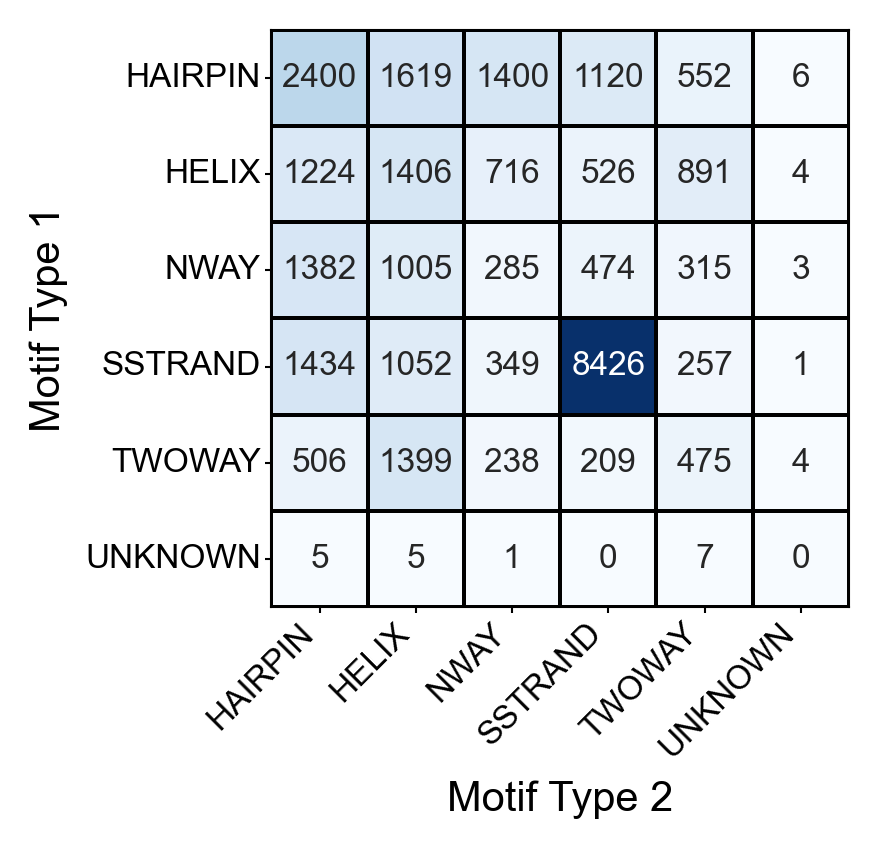

In [9]:
# Create pivot table of counts
pivot = pd.crosstab(df["mtype_1"], df["mtype_2"])

# Create heatmap
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = sns.heatmap(
    pivot,
    annot=True,
    fmt="d",
    cmap="Blues",
    square=True,
    linewidth=0.5,
    linecolor="black",
    cbar=False,
)

# Add border around whole plot
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color("black")

# Customize plot
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Motif Type 2")
plt.ylabel("Motif Type 1")
publication_style_ax(ax)